In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
from pyace import *

In [4]:
from pyace.linearacefit import LinearACEFit, LinearACEDataset

In [64]:
df0=pd.read_pickle("../Cu-II/Cu_df2_1k.pkl.gzip", compression="gzip")

In [6]:
df0.shape

(1000, 5)

In [7]:
df0["ase_atoms"].map(len).sum()

11309

In [8]:
# subsample large dataset if necessary
# df0 = df0.sample(n=100,random_state=42)

In [9]:
# split 95% train, 5% test
df_train=df0.sample(frac=0.95, random_state=42)
df_test = df0.loc[(i for i in df0.index if i not in df_train.index)]

In [10]:
len(df_train), len(df_test)

(950, 50)

In [11]:
# Create empty bbasis configuration
bconf = create_multispecies_basis_config(potential_config = {
  "deltaSplineBins": 0.001,
  "elements": ['Cu'],

  "embeddings": {
    "ALL": {
      "npot": 'FinnisSinclairShiftedScaled',
      "fs_parameters": [ 1, 1],
      "ndensity": 1,
    },
  },

  "bonds": {
    "ALL": {
      "radbase": "SBessel",
      "radparameters": [ 5.25 ],
      "rcut": 6,
      "dcut": 0.01,
    }
  },

  "functions": {
    # "number_of_functions_per_element": 1000,
    "ALL": {
        "nradmax_by_orders": [ 8, 8, 4, 3,2],
        "lmax_by_orders"   : [ 0, 4, 3, 2,1] }
  }
}
)

In [12]:
bconf.total_number_of_functions

822

# Prepare linear ACE dataset

In [13]:
train_ds = LinearACEDataset(bconf, df_train)

In [14]:
test_ds = LinearACEDataset(bconf, df_test)

Construct design matrix for train and test, by default - in parallel with 4 workers/processes. 
Set verbose=False to suppress output

In [15]:
train_ds.construct_design_matrix(verbose=True)
test_ds.construct_design_matrix(verbose=True)

[Proc-0]structures_chunk=(0, 238), atoms_chunk=(0, 2891)  # struct=238, #at = 2891
[Proc-1]structures_chunk=(238, 476), atoms_chunk=(2891, 5648)  # struct=238, #at = 2757
[Proc-2]structures_chunk=(476, 713), atoms_chunk=(5648, 8356)  # struct=237, #at = 2708
[Proc-3]structures_chunk=(713, 950), atoms_chunk=(8356, 10880)  # struct=237, #at = 2524
[Proc-2] 9/237 structures: [0.63/16.61s, 15.98 s remains]
[Proc-0] 9/238 structures: [0.73/19.40s, 18.67 s remains]
[Proc-2] 18/237 structures: [1.14/14.98s, 13.84 s remains]
[Proc-1] 9/238 structures: [1.76/46.43s, 44.67 s remains]
[Proc-2] 27/237 structures: [1.81/15.85s, 14.04 s remains]
[Proc-3] 9/237 structures: [2.09/55.06s, 52.97 s remains]
[Proc-0] 18/238 structures: [2.15/28.49s, 26.34 s remains]
[Proc-1] 18/238 structures: [2.68/35.39s, 32.72 s remains]
[Proc-3] 18/237 structures: [3.06/40.26s, 37.20 s remains]
[Proc-1] 27/238 structures: [3.30/29.11s, 25.81 s remains]
[Proc-2] 36/237 structures: [3.44/22.67s, 19.23 s remains]
[Proc-3

Create linear ACE fit class, provide train dataset

In [16]:
linear_fit = LinearACEFit(train_dataset=train_ds)

Call fit method, by default it use Ridge from sklearn

In [17]:
linear_fit.fit()

/home/yury/miniconda3/envs/ace/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.35292e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge(alpha=1e-05, copy_X=False, fit_intercept=False, random_state=42)

Compute error metrics on train and test (in eV/atom and eV/A)

In [18]:
linear_fit.compute_errors(train_ds)

{'epa_mae': 0.0036440569754229595,
 'epa_rmse': 0.005967649541668303,
 'f_comp_mae': 0.006675124619790396,
 'f_comp_rmse': 0.011920913143515888}

In [19]:
linear_fit.compute_errors(test_ds)

{'epa_mae': 0.0029914479958728004,
 'epa_rmse': 0.00461704855093892,
 'f_comp_mae': 0.005989990074728448,
 'f_comp_rmse': 0.01086427476454924}

## Trained basis export and usage

Get fitted basis and use in PyACECalculator

In [20]:
basis = linear_fit.get_bbasis()

In [21]:
calc = PyACECalculator(basis)

In [22]:
e_pred,f_pred = linear_fit.predict(test_ds, reshape_forces=True)

In [23]:
# take first  ase_atoms
at = df_test.iloc[0]["ase_atoms"].copy()

In [24]:
at.set_calculator(calc)

In [25]:
at.get_potential_energy()

/home/yury/miniconda3/envs/ace/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


-14.764174318021132

Compare PyACECalculator predictions with LinearFit predictions

In [26]:
np.allclose(at.get_potential_energy()/len(at),e_pred[0])

True

In [27]:
np.allclose(at.get_forces(),f_pred[:len(at)])

True

# Manual design matrix manipulation and fit

In [28]:
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA

Get design matrix explicitly

In [29]:
train_dm = train_ds.get_design_matrix()

Size of design matrix is  n_structures + 3 * n_atoms  by n_func.

First n_structures row correspond to summed up B-basis projections for each structure, divided by size of corresponding structure

Remaining 3 * n_atoms rows are corresponding x-,y- and z-force components for each atom

In [30]:
train_dm.shape

(33590, 822)

Get target vector explicitly

In [31]:
train_y = train_ds.get_target_vector()

Size of design matrix is  n_structures + 3 * n_atoms  by n_func

First n_structures row correspond to energy-per-atom each structure

Remaining 3 * n_atoms rows are corresponding x-,y- and z-force components for each atoms

In [32]:
train_y.shape

(33590,)

In [33]:
train_ds.total_number_of_structures + 3* train_ds.total_number_of_atoms

33590

In [34]:
B_funcs = train_dm[:train_ds.total_number_of_structures]

In [35]:
B_grad_funcs = train_dm[train_ds.total_number_of_structures:]

## Visualization of design matrix features (B-func and B-func grad)

Text(0, 0.5, 'B-func spread (max-min)')

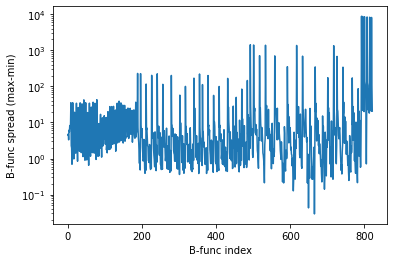

In [36]:
B_funcs_spread = B_funcs.max(axis=0)-B_funcs.min(axis=0)

plt.plot(B_funcs_spread)
plt.yscale('log');
plt.xlabel("B-func index")
plt.ylabel("B-func spread (max-min)")

Text(0, 0.5, 'B-grad-func spread (max-min)')

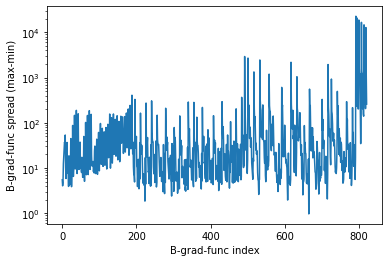

In [37]:
B_grad_funcs_spread = B_grad_funcs.max(axis=0)-B_grad_funcs.min(axis=0)

plt.plot(B_grad_funcs_spread)
plt.yscale('log');
plt.xlabel("B-grad-func index")
plt.ylabel("B-grad-func spread (max-min)")

## Create linear model manually

Create Ridge model

In [38]:
model = Ridge(alpha=1e-10, fit_intercept=False, copy_X=False, random_state=42, solver="auto")

In [39]:
model.fit(train_dm, train_y)

/home/yury/miniconda3/envs/ace/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.39291e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge(alpha=1e-10, copy_X=False, fit_intercept=False, random_state=42)

get model predictions on train design matrix

In [40]:
train_pred = model.predict(train_dm)

Extract energy-per-atom (epa) and forces from predicted vector

In [41]:
epa_pred = train_ds.get_energies_per_atom(train_pred)

In [42]:
f_pred = train_ds.get_forces(train_pred)

Compute error metrics for *train* dataset, using predicted EPA and forces.
Reference values are stored in dataset and used automatically, unless provided otherwise

In [43]:
train_ds.compute_errors(epa_pred, f_pred)

{'epa_mae': 0.0036495512161847134,
 'epa_rmse': 0.005990969296745907,
 'f_comp_mae': 0.00667100264536319,
 'f_comp_rmse': 0.011911568872160548}

## Using PCA for dimensionality reduction

In [44]:
pca = PCA()
train_dm_pca = pca.fit_transform(train_dm)

In [45]:
model = Ridge(alpha=1e-10, fit_intercept=False, copy_X=False, random_state=42, solver="auto")

In [46]:
model.fit(train_dm_pca, train_y)

/home/yury/miniconda3/envs/ace/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.06267e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge(alpha=1e-10, copy_X=False, fit_intercept=False, random_state=42)

In [47]:
train_pred = model.predict(train_dm_pca)

In [48]:
epa_pred = train_ds.get_energies_per_atom(train_pred)

In [49]:
f_pred = train_ds.get_forces(train_pred)

In [50]:
train_ds.compute_errors(epa_pred, f_pred)

{'epa_mae': 0.0941114902929369,
 'epa_rmse': 0.09430150398882028,
 'f_comp_mae': 0.0938204774890719,
 'f_comp_rmse': 0.09455558160179986}

## Fit of energies-only

In [51]:
B_funcs = train_dm[:train_ds.total_number_of_structures]

In [52]:
epa_ref = train_y[:train_ds.total_number_of_structures]

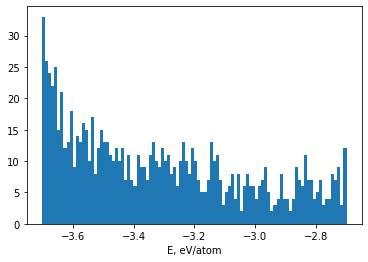

In [53]:
plt.hist(epa_ref,bins=100);
plt.xlabel("E, eV/atom");

In [54]:
model = Ridge(alpha=1e-10, fit_intercept=False, copy_X=False, random_state=42, solver="auto")

In [55]:
model.fit(B_funcs,epa_ref)

Ridge(alpha=1e-10, copy_X=False, fit_intercept=False, random_state=42)

In [56]:
epa_pred = model.predict(B_funcs)

In [57]:
# E-RMSE, meV/at
np.sqrt(np.mean((epa_pred-epa_ref)**2))*1e3 

0.3911348345455415

### Energies-only with PCA

In [58]:
B_funcs_pca = PCA().fit_transform(B_funcs)

In [59]:
B_funcs_pca_spread=B_funcs_pca.max(axis=0)-B_funcs_pca.min(axis=0)

Text(0, 0.5, 'B-func PCA spread (max-min)')

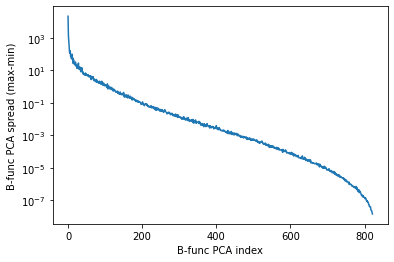

In [60]:
plt.plot(B_funcs_pca_spread)
plt.yscale('log');
plt.xlabel("B-func PCA index")
plt.ylabel("B-func PCA spread (max-min)")

In [61]:
model.fit(B_funcs_pca,epa_ref)

/home/yury/miniconda3/envs/ace/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.59317e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge(alpha=1e-10, copy_X=False, fit_intercept=False, random_state=42)

In [62]:
epa_pred_pca = model.predict(B_funcs_pca)

In [63]:
# E-RMSE, meV/at
np.sqrt(np.mean((epa_pred_pca-epa_ref)**2))*1e3 

3316.9605153475927